In [1]:
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import numpy as np
import re
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from xgboost import plot_tree
import graphviz
from xgboost import DMatrix
import time
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above
#browser.implicitly_wait(10) # probably unnecessary, just makes sure all pages you visit fully load


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_15006/2767767744.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


In [3]:
def scrape_stats(url):
    browser.get(url)
    time.sleep(7.5)
    select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
    select.select_by_visible_text('All')
    data = pd.read_html(browser.page_source)
    data[0] = data[0].replace('-', np.nan)
    data[0].dropna(axis = 1, how = 'all', inplace = True)
    data[0].dropna(axis = 0, how = 'any', inplace = True)
    if isinstance(data[0].columns, pd.MultiIndex):
        data[0].columns = data[0].columns.droplevel([1, 2, 3, 4])
        data[0].columns = data[0].columns.map(' '.join)
        data[0] = data[0].rename(columns=lambda x: re.sub('Unnamed: ._level_0','',x))
    data[0].columns = data[0].columns.str.replace(' ', '')
    data[0].columns = data[0].columns.str.replace(chr(160), '')
    data[0].columns = data[0].columns.str.upper()
    data[0].columns = data[0].columns.str.lstrip()
    return data

In [4]:
def get_salary(year):    
    url = "https://hoopshype.com/salaries/players/20{0}-20{1}/"
    url = url.format(str(year).zfill(2), str(year+1).zfill(2))
    if year == 21:
        url = "https://hoopshype.com/salaries/players/"
    browser.get(url)
    col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
    sal_df = pd.read_html(browser.page_source)[0]
    sal_df = sal_df.reset_index()
    sal_df = sal_df.drop_duplicates(subset = "Player", keep = "first")
    sal_df = sal_df.dropna(subset=[col])
    sal_df['Player'] = sal_df['Player'].str.split('\\').str[0]
    #sal_df = sal_df[~((sal_df["Signed Using"].str.contains("Pick", na=False)) & (sal_df['20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))] < 12632950.0))]
    sal_df = sal_df[['Player', col]]
    return sal_df

In [5]:
def get_year(year):
    return '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))

In [6]:
#data = scrape_stats("https://www.nba.com/stats/players/passing/?sort=AST_ADJ&dir=1")
#data[0]


In [7]:
toScrape = ["https://www.nba.com/stats/players/speed-distance/?Season=20{0}-{1}&SeasonType=Regular%20Season", 
 "https://www.nba.com/stats/players/shooting/?Season=20{0}-{1}&SeasonType=Regular%20Season", 
 "https://www.nba.com/stats/players/traditional/?Season=20{0}-{1}&SeasonType=Regular%20Season",
 "https://www.nba.com/stats/players/hustle/?Season=20{0}-{1}&SeasonType=Regular%20Season",
 "https://www.nba.com/stats/players/passing/?Season=20{0}-{1}&SeasonType=Regular%20Season"]

#toScrape = [i.format(str(year).zfill(2), str(year+1).zfill(2)) for i in toScrape]

In [8]:
info = ['PLAYER', 'MIN', 'GP']
features = ['OREB', 'DREB', 'REB', 'LESSTHAN5FT.FGM',  '10-14FT.FGM', '15-19FT.FGM', '20-24FT.FGM',
            'STL', 'BLK', 'ASTADJ', 'PASSESMADE', 'LOOSEBALLSRECOVERED', 'DEFLECTIONS', 'CONTESTED2PTSHOTS',
            'CONTESTED3PTSHOTS', '3PM', 'SCREENASSISTS']

other = ['AVGSPEED', 'AVGSPEEDOFF', 'AVGSPEEDDEF', 'AGE']

In [9]:
data = {}
data_norm = {}
sal = {}
full_data = {}
years = range(16, 22)

In [10]:
try:
    with open('full_data.pkl', 'rb') as f:
        full_data = pickle.load(f)
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    with open('data_norm.pkl', 'rb') as f:
        data_norm = pickle.load(f)
    with open('sal.pkl', 'rb') as f:
        sal = pickle.load(f)
except:
    for year in years:
        browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above
        for i, url in enumerate([i.format(str(year).zfill(2), str(year+1).zfill(2)) for i in toScrape]): 
            print(url)
            stats = scrape_stats(url)
            stats[0]
            #print(stats[0])
            if i == 0:
                data[year] = stats[0]
            else:
                data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
        data[year].rename(columns={'MIN_x':'MIN'}, inplace=True)
        data[year].rename(columns={'GP_x':'GP'}, inplace=True)
        data[year].drop(list(data[year].filter(regex = '_[xy]')), axis = 1, inplace = True)
        data[year] = data[year].loc[:,~data[year].columns.duplicated()]

        data_norm[year] = data[year].copy()

        data_norm[year][features] = data_norm[year][features].apply(pd.to_numeric, errors='coerce')
        data_norm[year][features] = data_norm[year][features].div(data[year]['MIN'], axis=0) * 36
        data_norm[year][features] = data_norm[year][features].apply(lambda x: np.log(x + 1))
        data_norm[year] = data_norm[year].dropna()
        data_norm[year]['TOTALMIN'] = data_norm[year]['MIN'] * data[year]['GP']
        data_norm[year] = data_norm[year][data_norm[year]['TOTALMIN'] > 350]

        browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above
        sal[year] = get_salary(year)    

        print("salary finished{}".format(year))

        full_data[year] = pd.merge(data_norm[year], sal[year], left_on=["PLAYER"], right_on=['Player'])

        col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
        full_data[year][col] = full_data[year][col].str.replace(',', '')
        full_data[year][col] = full_data[year][col].str.replace('$', '')
        full_data[year][col] = full_data[year][col].astype(int)

        print(year)

#full_data['2021-22'] = full_data['2021-22'].clip(upper = 35000000)


In [11]:
data_norm[16].shape

(383, 75)

In [12]:
import pickle
with open('full_data.pkl', 'wb') as file:
      pickle.dump(full_data, file)
with open('data.pkl', 'wb') as file:
      pickle.dump(data, file)
with open('sal.pkl', 'wb') as file:
      pickle.dump(sal, file)
with open('data_norm.pkl', 'wb') as file:
      pickle.dump(data_norm, file)       

In [13]:
data

{16:               PLAYER  GP   MIN  DIST.FEET  DIST.MILES  DIST.MILESOFF  \
 0         AJ Hammons  22   7.4     2571.2        0.49           0.25   
 1       Aaron Brooks  64  13.6     4953.5        0.94           0.51   
 2       Aaron Gordon  80  28.7    11234.2        2.13           1.14   
 3     Aaron Harrison   5   3.3     1180.8        0.22           0.12   
 4      Adreian Payne  18   7.5     2840.5        0.54           0.29   
 ..               ...  ..   ...        ...         ...            ...   
 481  Wilson Chandler  70  30.9    10906.6        2.07           1.11   
 482     Yogi Ferrell  46  26.0    10053.1        1.90           1.04   
 483      Zach LaVine  47  37.2    14327.9        2.71           1.46   
 484    Zach Randolph  73  24.5     8471.1        1.60           0.86   
 485    Zaza Pachulia  70  18.1     6674.3        1.26           0.63   
 
      DIST.MILESDEF  AVGSPEED  AVGSPEEDOFF  AVGSPEEDDEF  ...   W   L  \
 0             0.23      3.94         4.16    

In [14]:
stat = 'PTS'
data_norm[20][['PLAYER', 'MIN',stat]].sort_values(stat, ascending=False).head(5)

,PLAYER,MIN,PTS
470,Stephen Curry,34.1,32.0
45,Bradley Beal,35.8,31.3
95,Damian Lillard,35.8,28.8
260,Joel Embiid,31.1,28.5
184,Giannis Antetokounmpo,33.0,28.1


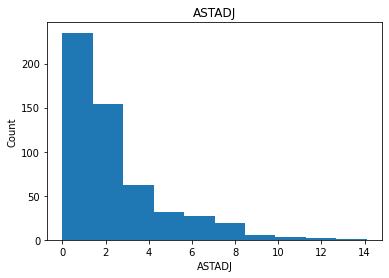

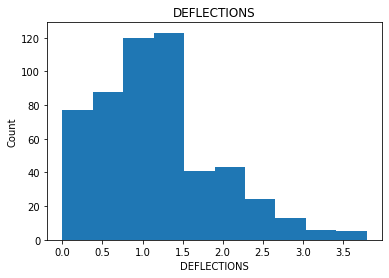

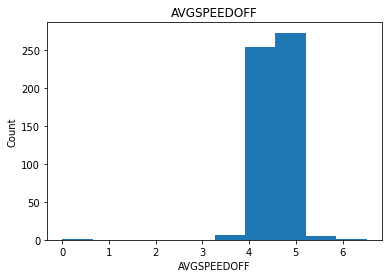

In [15]:
for item in ["ASTADJ", "DEFLECTIONS", "AVGSPEEDOFF"]:
    if data[20][item].dtypes != 'O':
        data[20].hist(item, grid=False)
        pyplot.xlabel(item)
        pyplot.ylabel("Count")
        pyplot.savefig("{}_raw.png".format(item))

In [16]:
stat = "AVGSPEEDOFF"
year = 18
data_norm[year][["PLAYER", stat]].sort_values(by=[stat], ascending = False).head(15).style.format({stat: "{:20,.2f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)

/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_15006/3382176679.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  data_norm[year][["PLAYER", stat]].sort_values(by=[stat], ascending = False).head(15).style.format({stat: "{:20,.2f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)


PLAYER,AVGSPEEDOFF
Damion Lee,5.30
Tyrone Wallace,5.21
Landry Shamet,5.20
Buddy Hield,5.18
Davis Bertans,5.17
Joe Harris,5.17
Rodions Kurucs,5.13
Ish Smith,5.13
Alfonzo McKinnie,5.10
T.J. McConnell,5.09


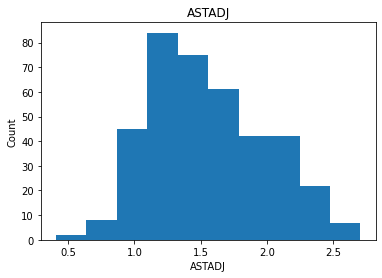

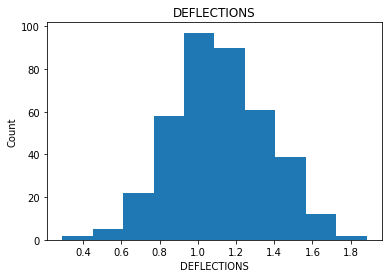

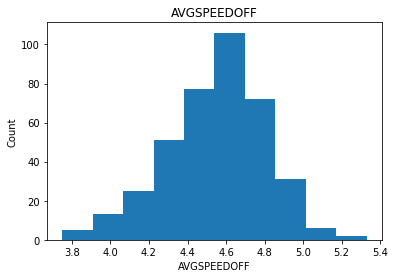

In [17]:

 
for item in ['ASTADJ', 'DEFLECTIONS', 'AVGSPEEDOFF']:
    if data_norm[20][item].dtypes != 'O':
        data_norm[20].hist(item, grid=False)
        pl.xlabel(item)
        pl.ylabel("Count")
        plt.savefig("{}.png".format(item))


In [18]:
stat = 'DEFLECTIONS'
year = 20
data_norm[year][['PLAYER', 'TOTALMIN',stat]].sort_values(stat, ascending=False).head(15).style.format({get_year(year): "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)

/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_15006/2120018578.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  data_norm[year][['PLAYER', 'TOTALMIN',stat]].sort_values(stat, ascending=False).head(15).style.format({get_year(year): "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)


PLAYER,TOTALMIN,DEFLECTIONS
Matisse Thybulle,"1,300.0",1.884035
T.J. McConnell,"1,794.0",1.765784
Dennis Smith Jr.,420.9,1.709209
De'Anthony Melton,"1,045.2",1.700669
Facundo Campazzo,"1,423.5",1.693477
Javonte Green,475.6,1.676129
Killian Hayes,670.8,1.672522
Nerlens Noel,"1,548.8",1.641961
Robert Covington,"2,240.0",1.619388
Larry Nance Jr.,"1,092.0",1.593934


In [19]:
# sal_df = pd.read_excel('2022salaries.xlsx', header = 1)
# sal_df = sal_df.drop_duplicates(subset = "Player", keep = "first")
# sal_df = sal_df.dropna(subset=['2021-22'])
# sal_df['Player'] = sal_df['Player'].str.split('\\').str[0]
# sal_df = sal_df[~((sal_df["Signed Using"].str.contains("Pick", na=False)) & (sal_df["2021-22"] < 12632950.0))]
# sal_df = sal_df[['Player', '2021-22']]

In [20]:
# url = "https://hoopshype.com/salaries/players/20{0}-20{1}/"

# url = url.format(str(year).zfill(2), str(year+1).zfill(2))
# browser.get(url)
# #select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
# #select.select_by_visible_text('All')
# col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
# sal_df = pd.read_html(browser.page_source)[0]
# sal_df = sal_df.reset_index()
# sal_df = sal_df.drop_duplicates(subset = "Player", keep = "first")
# sal_df = sal_df.dropna(subset=[col])
# sal_df['Player'] = sal_df['Player'].str.split('\\').str[0]
# #sal_df = sal_df[~((sal_df["Signed Using"].str.contains("Pick", na=False)) & (sal_df['20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))] < 12632950.0))]
# sal_df = sal_df[['Player', col]]
# sal_df

In [21]:
full_data[20]

,PLAYER,GP,MIN,DIST.FEET,DIST.MILES,DIST.MILESOFF,DIST.MILESDEF,AVGSPEED,AVGSPEEDOFF,AVGSPEEDDEF,...,PASSESRECEIVED,SECONDARYAST,POTENTIALAST,ASTPTSCREATED.1,ASTADJ,ASTTOPASS%,ASTTOPASS%ADJ,TOTALMIN,Player,2020/21
0,Aaron Gordon,50,27.7,10476.6,1.98,1.10,0.89,4.06,4.40,3.71,...,34.0,0.6,5.7,8.1,1.824316,9.8,12.3,1385.0,Aaron Gordon,18136364
1,Aaron Holiday,66,17.8,7271.3,1.38,0.71,0.66,4.32,4.70,3.98,...,20.5,0.3,3.3,5.0,1.767114,12.1,15.8,1174.8,Aaron Holiday,2345640
2,Aaron Nesmith,46,14.5,5977.7,1.13,0.59,0.54,4.34,4.53,4.15,...,9.0,0.1,1.0,1.2,0.912144,4.3,5.2,667.0,Aaron Nesmith,3458400
3,Abdel Nader,24,14.8,6038.0,1.14,0.62,0.53,4.41,4.75,4.10,...,11.3,0.0,1.1,2.1,1.159767,8.4,9.7,355.2,Abdel Nader,1752950
4,Al Horford,28,27.9,10105.0,1.91,1.06,0.85,3.89,4.20,3.57,...,39.7,0.1,5.2,8.6,1.775499,8.7,9.7,781.2,Al Horford,27500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Xavier Tillman,59,18.4,7487.3,1.42,0.75,0.67,4.39,4.77,4.02,...,16.4,0.1,2.3,3.3,1.369856,5.3,6.1,1085.6,Xavier Tillman,1300000
344,Yuta Watanabe,50,14.5,6413.2,1.21,0.67,0.54,4.68,5.18,4.19,...,10.9,0.2,1.6,2.0,1.316686,5.6,7.4,725.0,Yuta Watanabe,737996
345,Zach LaVine,58,35.1,14326.0,2.71,1.49,1.22,4.37,4.81,3.93,...,56.6,0.9,9.8,12.6,2.009762,12.1,15.8,2035.8,Zach LaVine,19500000
346,Zeke Nnaji,42,9.5,3904.2,0.74,0.40,0.34,4.36,4.61,4.10,...,5.9,0.0,0.4,0.5,0.759329,3.6,4.3,399.0,Zeke Nnaji,2379840


In [22]:
for year in years:
    
    upper = 12000000
    lower = 0
    full_data[year] = full_data[year][~((full_data[year][get_year(year)] <= upper) & (full_data[year][get_year(year)] >= lower) & (full_data[year]["AGE"] <= 24))]
    full_data[year][get_year(year)] = full_data[year][get_year(year)].clip(upper = 40000000)



/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_15006/99714648.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data[year][get_year(year)] = full_data[year][get_year(year)].clip(upper = 40000000)


In [23]:
full_data[20].sort_values(by="AGE").head(5)

,PLAYER,GP,MIN,DIST.FEET,DIST.MILES,DIST.MILESOFF,DIST.MILESDEF,AVGSPEED,AVGSPEEDOFF,AVGSPEEDDEF,...,PASSESRECEIVED,SECONDARYAST,POTENTIALAST,ASTPTSCREATED.1,ASTADJ,ASTTOPASS%,ASTTOPASS%ADJ,TOTALMIN,Player,2020/21
34,Brandon Ingram,61,34.3,13369.0,2.53,1.41,1.12,4.16,4.65,3.68,...,49.1,0.9,8.9,12.3,2.015874,12.8,16.4,2092.3,Brandon Ingram,27285000
157,Jamal Murray,48,35.5,13897.4,2.63,1.44,1.19,4.22,4.56,3.88,...,57.4,1.0,9.6,12.2,1.986136,10.1,13.0,1704.0,Jamal Murray,27285000
192,Julius Randle,71,37.6,13982.9,2.65,1.48,1.17,3.99,4.34,3.61,...,57.5,0.5,11.2,15.9,2.016320,10.6,11.9,2669.6,Julius Randle,19845000
95,Domantas Sabonis,62,36.0,14235.6,2.70,1.43,1.26,4.21,4.58,3.85,...,56.7,0.3,11.4,17.4,2.140066,8.9,9.9,2232.0,Domantas Sabonis,19800000
166,Jaylen Brown,58,34.5,13405.5,2.54,1.36,1.18,4.13,4.45,3.81,...,42.1,0.4,5.7,8.7,1.663597,11.0,13.4,2001.0,Jaylen Brown,25035118


In [24]:
full_data[20]

,PLAYER,GP,MIN,DIST.FEET,DIST.MILES,DIST.MILESOFF,DIST.MILESDEF,AVGSPEED,AVGSPEEDOFF,AVGSPEEDDEF,...,PASSESRECEIVED,SECONDARYAST,POTENTIALAST,ASTPTSCREATED.1,ASTADJ,ASTTOPASS%,ASTTOPASS%ADJ,TOTALMIN,Player,2020/21
0,Aaron Gordon,50,27.7,10476.6,1.98,1.10,0.89,4.06,4.40,3.71,...,34.0,0.6,5.7,8.1,1.824316,9.8,12.3,1385.0,Aaron Gordon,18136364
4,Al Horford,28,27.9,10105.0,1.91,1.06,0.85,3.89,4.20,3.57,...,39.7,0.1,5.2,8.6,1.775499,8.7,9.7,781.2,Al Horford,27500000
11,Andre Drummond,46,27.0,9821.8,1.86,0.96,0.90,3.89,3.98,3.79,...,28.1,0.3,3.4,4.9,1.466337,5.9,7.1,1242.0,Andre Drummond,28751774
12,Andre Iguodala,63,21.3,8312.4,1.57,0.83,0.74,4.13,4.41,3.85,...,21.8,0.1,4.7,6.3,1.746133,7.7,9.6,1341.9,Andre Iguodala,15000000
13,Andrew Wiggins,71,33.3,12883.9,2.44,1.28,1.16,4.17,4.56,3.81,...,36.4,0.6,4.8,6.2,1.445328,8.3,10.4,2364.3,Andrew Wiggins,29542010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,Tony Snell,47,21.1,7903.1,1.50,0.79,0.70,3.99,4.17,3.81,...,13.0,0.1,2.2,3.2,1.220424,8.3,9.2,991.7,Tony Snell,12178571
326,Trevor Ariza,30,28.0,10716.3,2.03,1.04,0.99,4.09,4.24,3.94,...,21.1,0.1,3.6,4.8,1.342492,6.7,8.0,840.0,Trevor Ariza,12800000
337,Victor Oladipo,33,32.7,12708.4,2.41,1.29,1.12,4.27,4.64,3.91,...,49.3,0.9,7.5,11.8,1.984475,12.1,15.2,1079.1,Victor Oladipo,21000000
340,Will Barton,56,31.0,11789.4,2.23,1.20,1.04,4.11,4.34,3.89,...,36.0,0.6,5.6,8.1,1.751161,10.3,13.0,1736.0,Will Barton,13723214


In [25]:
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}
model = {}


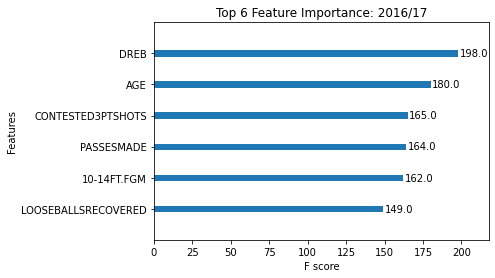

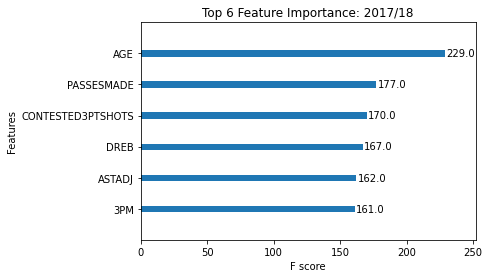

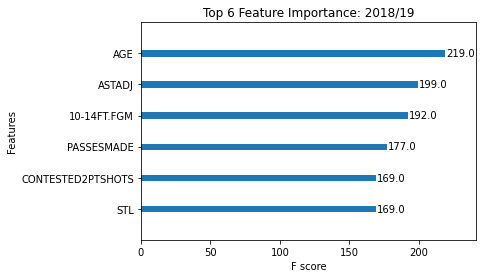

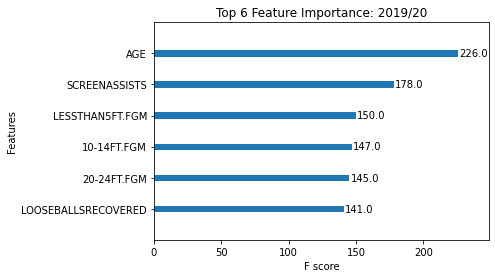

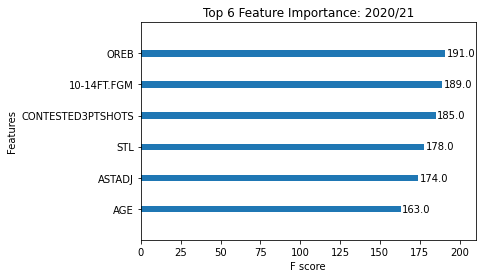

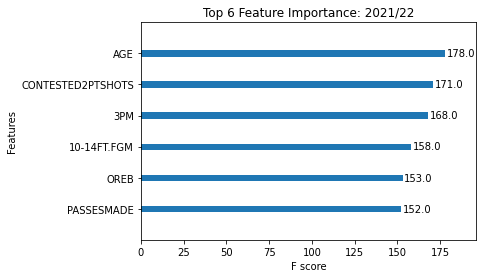

In [26]:
feat_importance = {k: [] for k in features+other}

for year in years:
    col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
    X[year], y[year] = full_data[year][features+other], full_data[year][col]
    model = XGBClassifier(random_state=7)
    le = LabelEncoder()
    y[year] = le.fit_transform(y[year])
    model.fit(X[year], y[year])
    plot_importance(model, importance_type="weight", max_num_features=6,grid=False,title='Top 6 Feature Importance: {}'.format(get_year(year)))
#plot_importance(model, importance_type="weight", max_num_features=5, grid=False,title='Feature Importance')

#pyplot.rcParams['figure.figsize'] = [20, 20]

    pyplot.show()
    for key, value in model.get_booster().get_fscore().items():
        #print(key, value)
        feat_importance[key].append(value)


In [27]:
feat_importance

{'OREB': [107.0, 136.0, 161.0, 141.0, 191.0, 153.0],
 'DREB': [198.0, 167.0, 167.0, 99.0, 123.0, 148.0],
 'REB': [64.0, 85.0, 115.0, 96.0, 92.0, 106.0],
 'LESSTHAN5FT.FGM': [118.0, 161.0, 158.0, 150.0, 139.0, 136.0],
 '10-14FT.FGM': [162.0, 152.0, 192.0, 147.0, 189.0, 158.0],
 '15-19FT.FGM': [142.0, 149.0, 126.0, 123.0, 144.0, 147.0],
 '20-24FT.FGM': [140.0, 117.0, 156.0, 145.0, 104.0, 124.0],
 'STL': [92.0, 152.0, 169.0, 101.0, 178.0, 118.0],
 'BLK': [134.0, 126.0, 136.0, 125.0, 124.0, 129.0],
 'ASTADJ': [106.0, 162.0, 199.0, 119.0, 174.0, 130.0],
 'PASSESMADE': [164.0, 177.0, 177.0, 138.0, 152.0, 152.0],
 'LOOSEBALLSRECOVERED': [149.0, 129.0, 152.0, 141.0, 122.0, 150.0],
 'DEFLECTIONS': [113.0, 120.0, 144.0, 117.0, 147.0, 142.0],
 'CONTESTED2PTSHOTS': [78.0, 110.0, 169.0, 86.0, 158.0, 171.0],
 'CONTESTED3PTSHOTS': [165.0, 170.0, 161.0, 133.0, 185.0, 148.0],
 '3PM': [128.0, 161.0, 127.0, 109.0, 109.0, 168.0],
 'SCREENASSISTS': [121.0, 129.0, 137.0, 178.0, 106.0, 119.0],
 'AVGSPEED': [

In [28]:
type(feat_importance.items())

dict_items

In [29]:
last_val = {k: v[-1] for k, v in feat_importance.items()}

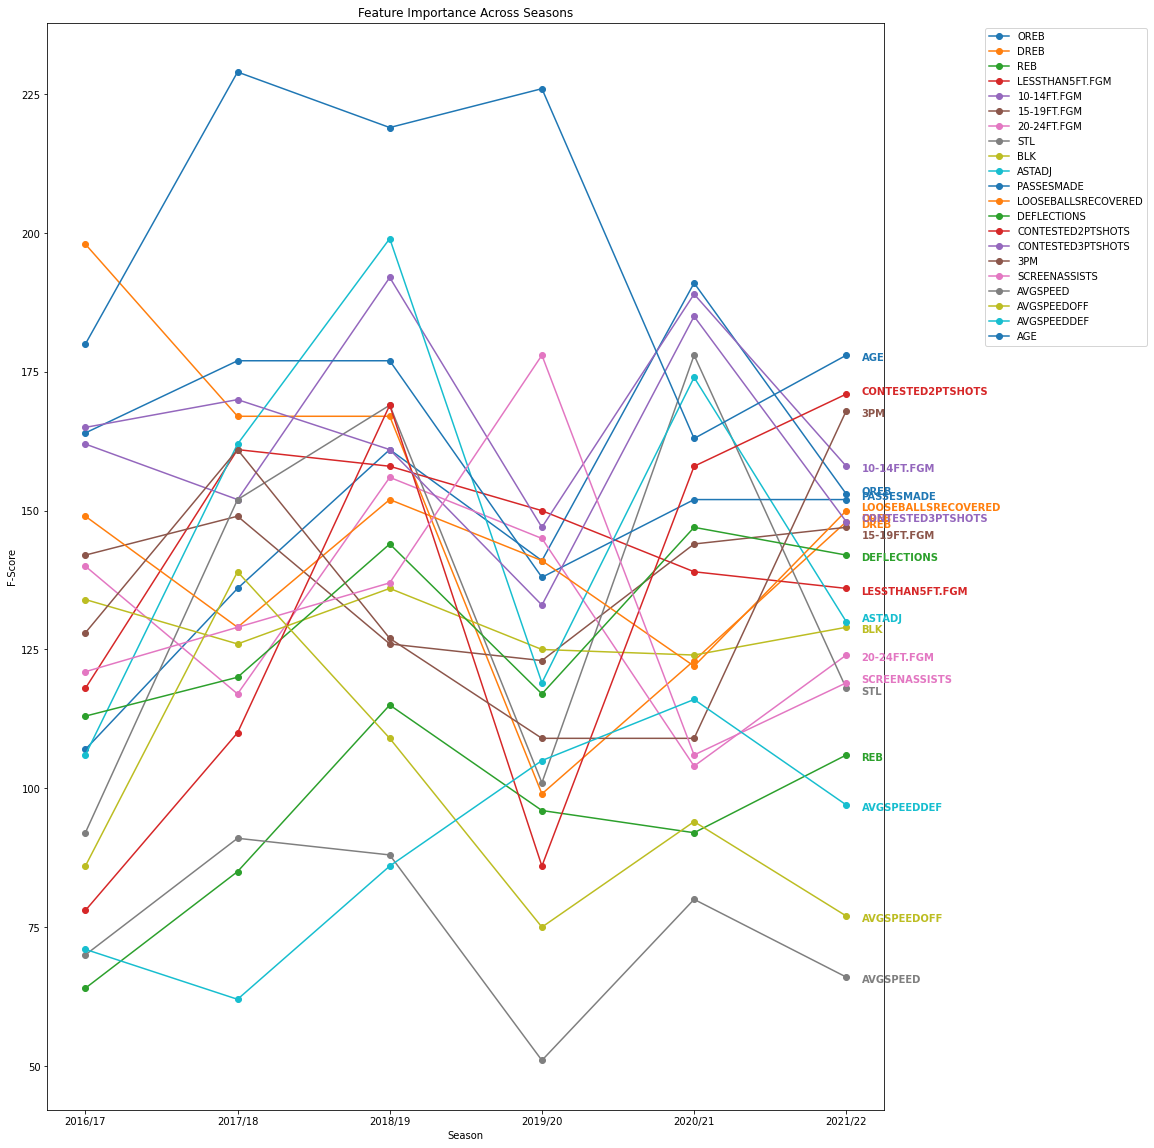

In [121]:
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(15,20))
ax = plt.subplot(111)
colors = {}
for key, value in feat_importance.items():
    t = ax.plot([get_year(year) for year in years], value,label=key,linestyle='-', marker='o')
    colors[key] = t[0].get_color()
    #plt.annotate("BRUH", [0, 10])
plt.xlabel('Season')
plt.ylabel('F-Score')
plt.title("Feature Importance Across Seasons")
#plt.legend()
last = -1
for num, (key, value) in enumerate(sorted(last_val.items(), key=lambda item:item[1])):
    if key == "DREB":
        ax.annotate(key, [5.1, value-1], color=colors[key],weight="bold")
    if key == "15-19FT.FGM":
        ax.annotate(key, [5.1, value-2], color=colors[key],weight="bold")
    else:
        if last!= -1 and value-last < 5:
            ax.annotate(key, [5.1, value], color=colors[key],weight="bold")
        else:
            ax.annotate(key, [5.1, value-1], color=colors[key],weight="bold")
        
    last = value
    
ax.legend(bbox_to_anchor=(1.32, 1.0))


In [31]:
y[20]

array([34, 51, 57, 20, 60, 66, 63, 69, 33, 32, 57, 50,  5, 46, 58, 25, 75,
       12, 33, 22,  4, 56, 65, 37, 21, 20, 54, 18, 59, 39, 45, 27, 26, 29,
       43, 38, 53, 33, 55, 30, 44, 11, 50, 75, 23, 47, 36, 71, 24, 60, 75,
       20, 49, 40, 10,  8, 59, 71,  7, 71,  0, 75, 64, 67, 59, 62, 68, 31,
       74, 41, 14,  9, 72, 33, 60, 48, 63, 13, 73, 28,  1, 19, 52, 75, 75,
       61,  3, 15, 35, 16, 70,  2,  6, 42, 17, 37])

In [32]:
X, y = full_data[features+other], full_data[col]

TypeError: unhashable type: 'list'

In [ ]:
data_dmatrix = DMatrix(data=X,label=y)

In [ ]:
from xgboost import train
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
xg_reg = train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
plot_tree(xg_reg,num_trees=0)
#pyplot.rcParams['figure.figsize'] = [100, 100]
pyplot.show()

In [ ]:
plot_importance(xg_reg, )

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(X, y)

In [ ]:
plot_importance(model, importance_type="weight", grid=False,title='Feature Importance')
#plot_importance(model, importance_type="weight", max_num_features=5, grid=False,title='Feature Importance')

#pyplot.rcParams['figure.figsize'] = [20, 20]

pyplot.show()

In [ ]:
full_data[18][(full_data[18]["AGE"] < 26) & (full_data[18]["2018/19"] < 13500000)]

In [149]:
stat = '3PM'
year = 21
full_data[year][['PLAYER', 'TEAM', 'TOTALMIN',stat, get_year(year)]].sort_values(stat, ascending=False).reset_index(drop=True).head(15).style.format({get_year(year): "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat, get_year(year)], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=get_year(year)).bar(subset=[stat], color='#FFA07A')

/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_15006/1824617080.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  full_data[year][['PLAYER', 'TEAM', 'TOTALMIN',stat, get_year(year)]].sort_values(stat, ascending=False).reset_index(drop=True).head(15).style.format({get_year(year): "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat, get_year(year)], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=get_year(year)).bar(subset=[stat], color='#FFA07A')


PLAYER,TEAM,TOTALMIN,3PM,2021/22
Stephen Curry,GSW,"2,208.0",1.739703,"$ 40,000,000"
Klay Thompson,GSW,940.8,1.687910,"$ 37,980,720"
Malik Beasley,MIN,"1,975.0",1.671473,"$ 14,491,964"
Duncan Robinson,MIA,"2,046.1",1.615597,"$ 15,650,000"
Kevin Love,CLE,"1,665.0",1.609438,"$ 31,258,256"
Buddy Hield,IND,"2,472.0",1.553535,"$ 23,073,234"
Donovan Mitchell,UTA,"2,264.6",1.553462,"$ 28,103,500"
Evan Fournier,NYK,"2,314.7",1.544581,"$ 17,142,857"
Luke Kennard,LAC,"1,918.0",1.514566,"$ 13,347,727"
Fred VanVleet,TOR,"2,463.5",1.507297,"$ 19,675,926"


In [ ]:
stat = 'SCREENASSISTS'
year = 20
full_data[year][['PLAYER', 'TEAM', 'TOTALMIN',stat, get_year(year)]].sort_values(stat, ascending=False).reset_index(drop=True).head(15).style.format({get_year(year): "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat, get_year(year)], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=get_year(year)).bar(subset=[stat], color='#FFA07A')

In [ ]:
avg_df = scrape_stats("https://www.nba.com/stats/players/shooting/?Season=2021-22&SeasonType=Regular%20Season&PerMode=Totals")

In [ ]:
avg = avg_df[0].copy()
avg = avg.dropna()
avg = avg.apply(pd.to_numeric, errors='ignore')
avg = avg.append(avg.sum(numeric_only=True), ignore_index=True)

for item in avg.columns:
    if "%" in item:
        print(item)
        avg.iloc[-1, avg.columns.get_loc(item)] = avg.iloc[-1, avg.columns.get_loc(item)-2]/avg.iloc[-1, avg.columns.get_loc(item)-1]
avg.iloc[-1]

In [ ]:
url = "https://www.spotrac.com/nba/free-agents/2019/"
browser.get(url)
#select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
#select.select_by_visible_text('All')
df = pd.read_html(browser.page_source)[0]

In [ ]:
url = "https://hoopshype.com/salaries/players/2015-2016/"
browser.get(url)
#select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
#select.select_by_visible_text('All')
df = pd.read_html(browser.page_source)[0]
df = df . reset_index()
df

In [ ]:
shots = pd.DataFrame(columns=['DIST','FGM', 'FGA', 'FG%'])

In [ ]:
df2 = {'DIST': "0-5 FT", 'FGM': 32492, 'FGA': 51954, 'FG%': 0.625399}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "5-9 FT", 'FGM': 7390, 'FGA': 17872, 'FG%': 0.413496}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "10-14 FT", 'FGM': 5600, 'FGA': 13031, 'FG%': 0.429744}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "15-19 FT", 'FGM': 4513, 'FGA': 10902, 'FG%': 0.413961}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "20-24 FT", 'FGM': 9552, 'FGA': 25698, 'FG%': 0.371702}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "25-29 FT", 'FGM': 13722, 'FGA': 40044, 'FG%': 0.342673}
shots = shots.append(df2, ignore_index = True)

In [ ]:
shots.head(15).style.format().set_properties(**{'text-align': 'right'}).set_properties( subset=['DIST', 'FGM', 'FGA', 'FG%'], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=['FG%', 'FGM']).bar(subset=["FGA"], color='#FFA07A')